In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from sklearn.linear_model import LinearRegression

In [3]:
df=pd.read_csv('steam_data.csv')
df.head()

,id,title,release_date,recent_reviews,all_reviews,price,developers,number_languages,compatible_os,tags
0,302970,Radiant Defense,"11 Jul, 2014","['83', '95']","['83', '95']","['4,99']",['Hexage'],7,1,"['Strategy', 'Indie', 'TowerDefense']"
1,1329600,Karting,"15 Apr, 2021","['85', '14', '30']","['88', '326']","['1,99']",['RewindApp'],1,1,"['Racing', 'Casual', 'Multiplayer', 'Simulatio..."
2,1073820,"Love, Sam","31 May, 2019","['94', '175']","['94', '175']","['2,39']",['Korean Linguistics Lab'],1,1,"['Adventure', 'Indie', 'Violent', 'Horror', 'P..."
3,714800,Maitetsu,"29 Jun, 2018","['95', '285']","['95', '285']","['12,49']",['Lose'],2,1,"['Cute', 'Anime', 'VisualNovel', 'Trains', 'Ca..."
4,203990,SATAZIUS,"16 Dec, 2011","['90', '151']","['90', '151']",NaN,['ASTRO PORT'],2,2,"[""Shoot'EmUp"", 'Indie', 'Action', 'Arcade', '2..."


Before beginning with the data analysis, we created some new columns in the data base scraped, that could help us on building plots and getting insights.

In [4]:
#Adding new column with prices as float
price=[]
for p in df.price:
    if type(p)==str and len(p)!=2:
        pp=p.replace(',','.').replace('[','').replace(']','').replace("'",'')
        if pp.replace('.','').isnumeric():
            price.append(float(pp))
        else:
            price.append(0)
    elif type(p)==str and len(p)==2:
        price.append(0)
    elif np.isnan(p):
        price.append(0)
    else:
        price.append(p)
df['price_float']=price

In [5]:
#Adding new column with the range of prices classification

df.loc[(df['price_float']==0),'price_range']='0'
df.loc[(df['price_float']>0)&(df['price_float']<=10),'price_range']='1-10'
df.loc[(df['price_float']>10)&(df['price_float']<=20),'price_range']='11-20'
df.loc[(df['price_float']>20)&(df['price_float']<=30),'price_range']='21-30'
df.loc[(df['price_float']>30)&(df['price_float']<=40),'price_range']='31-40'
df.loc[(df['price_float']>40)&(df['price_float']<=50),'price_range']='41-50'
df.loc[(df['price_float']>50)&(df['price_float']<=60),'price_range']='51-60'
#df.head()

In [6]:
#Adding new column with the total positives reviews as float
positive_reviews=[]
for a in df.all_reviews:
    if type(a)==str:
        positive_reviews.append(int(float(a[2:4])))
    elif np.isnan(a):
        positive_reviews.append(0)
        
df['positive_reviews']=positive_reviews

In [7]:
#Adding new column with the total reviews as float in thousands
total_reviews=[]
for b in df.all_reviews:
    if type(b)==str and b[4]=="'" and len(b)<=17:
        total_reviews.append((float(b[8:-2].replace(',','')))/1000)
    elif type(b)==str and b[4]!="'" and len(b)<=17:
        total_reviews.append((float(b[9:-2].replace(',','')))/1000)
    elif type(b)==str and b[4]=="'" and len(b)>17:
        total_reviews.append((float(b[8:-10].replace(',','')+b[-5:-2]))/1000)
    elif type(b)==str and b[4]!="'" and len(b)>17:
        total_reviews.append((float(b[9:-10].replace(',','')+b[-5:-2]))/1000)
    elif np.isnan(b):
        total_reviews.append(0)

df['total_reviews']=total_reviews

In [8]:
#Adding new column identifying the 5 stars games
df.loc[(df['positive_reviews']>=95),'five_stars']=1
df.loc[(df['positive_reviews']<95),'five_stars']=0
#df.head()

In [9]:
#Adding new column with the age of the games in years

age=[]
for c in df.release_date:
    if type(c)==str and c[-4:].isnumeric(): #c!='Soon™' and c[-3]!='.':
        age.append(int(2022-float(c[-4:])))
    elif type(c)==str:
        age.append(0)
    else:
        age.append(0)
        
df['age']=age

In [10]:
#Adding new column with the quantity of tags
tags=[]
j=0
for tt in df.tags:
    if type(tt)==float:
        tags.append(0)
    else:
        for t in tt:
            if t == ',':
                j+=1
        n_tags=j+1
        tags.append(n_tags)
        j=0
df['n_tags']=tags
#df.head()

The final data base:

In [11]:
df.head()

,id,title,release_date,recent_reviews,all_reviews,price,developers,number_languages,compatible_os,tags,price_float,price_range,positive_reviews,total_reviews,five_stars,age,n_tags
0,302970,Radiant Defense,"11 Jul, 2014","['83', '95']","['83', '95']","['4,99']",['Hexage'],7,1,"['Strategy', 'Indie', 'TowerDefense']",4.99,1-10,83,0.095,0.0,8,3
1,1329600,Karting,"15 Apr, 2021","['85', '14', '30']","['88', '326']","['1,99']",['RewindApp'],1,1,"['Racing', 'Casual', 'Multiplayer', 'Simulatio...",1.99,1-10,88,0.326,0.0,1,15
2,1073820,"Love, Sam","31 May, 2019","['94', '175']","['94', '175']","['2,39']",['Korean Linguistics Lab'],1,1,"['Adventure', 'Indie', 'Violent', 'Horror', 'P...",2.39,1-10,94,0.175,0.0,3,5
3,714800,Maitetsu,"29 Jun, 2018","['95', '285']","['95', '285']","['12,49']",['Lose'],2,1,"['Cute', 'Anime', 'VisualNovel', 'Trains', 'Ca...",12.49,11-20,95,0.285,1.0,4,15
4,203990,SATAZIUS,"16 Dec, 2011","['90', '151']","['90', '151']",NaN,['ASTRO PORT'],2,2,"[""Shoot'EmUp"", 'Indie', 'Action', 'Arcade', '2...",0.00,0,90,0.151,0.0,11,9


As we want to analyse the success of the game based on its review score, we created some figures that could help us better understand visually the sample we took.

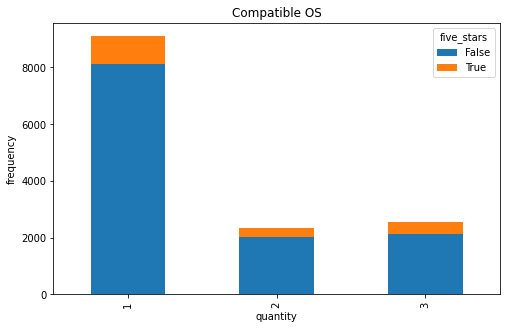

In [12]:
#Figure 1 - Compatible OS

table_OS=pd.crosstab(df.compatible_os,df.five_stars.astype(bool))
table_OS.plot(kind='bar',stacked=True,figsize=(8, 5))
plt.title('Compatible OS')
plt.xlabel('quantity')
plt.ylabel('frequency')
plt.show()

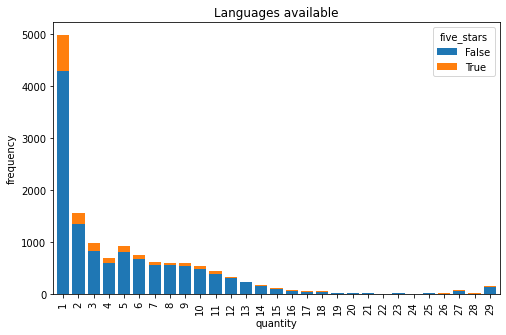

In [13]:
#Figure 2 - Languages available

table_langue=pd.crosstab(df.number_languages[df.number_languages>0],df.five_stars[df.number_languages>0].astype(bool))
table_langue.plot(kind='bar',stacked=True,width=0.8,figsize=(8, 5))
plt.title('Languages available')
plt.xlabel('quantity')
plt.ylabel('frequency')
plt.show()

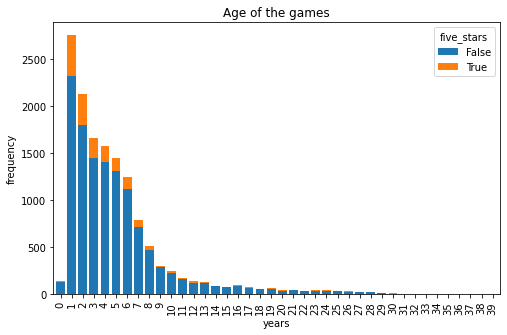

In [14]:
#Figure 3 - Age of the games

table_age=pd.crosstab(df.age,df.five_stars.astype(bool))
table_age.plot(kind='bar',stacked=True,width=0.8,figsize=(8, 5))
plt.title('Age of the games')
plt.xlabel('years')
plt.ylabel('frequency')
plt.show()

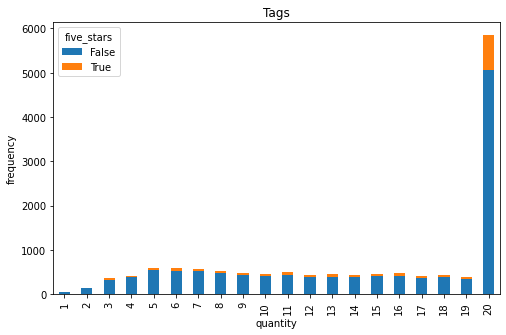

In [15]:
#Figure 4 - Quantity of tags

table_tags=pd.crosstab(df.n_tags,df.five_stars.astype(bool))
table_tags.plot(kind='bar',stacked=True,figsize=(8, 5))
plt.title('Tags')
plt.xlabel('quantity')
plt.ylabel('frequency')
plt.show()

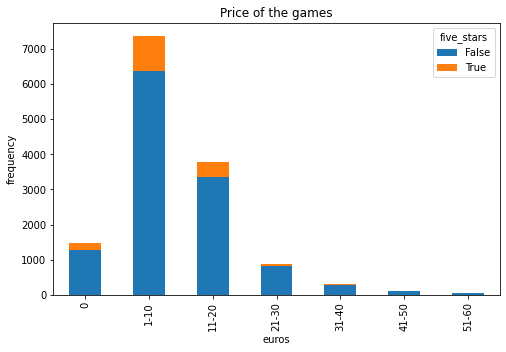

In [16]:
#Figure 5 - Price of the games

table_price=pd.crosstab(df.price_range,df.five_stars.astype(bool))
table_price.plot(kind='bar',stacked=True,figsize=(8, 5))
plt.title('Price of the games')
plt.xlabel('euros')
plt.ylabel('frequency')
plt.show()

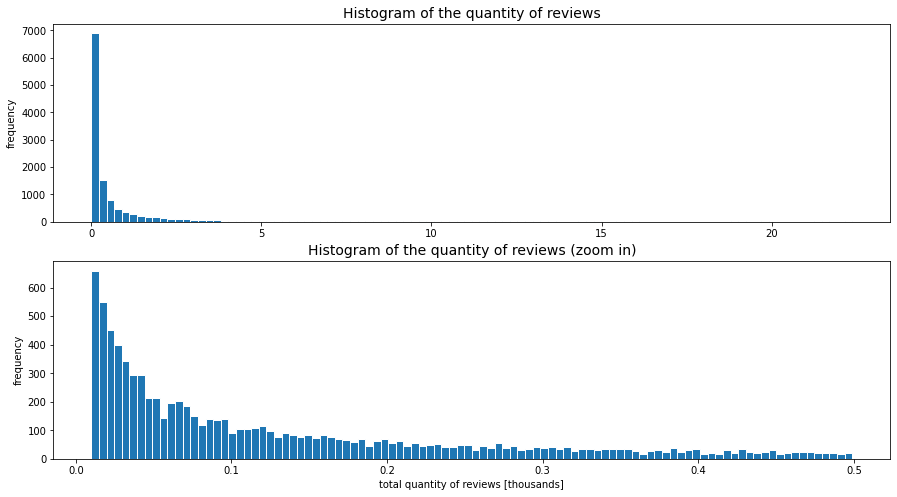

In [17]:
#Figure 6 - Distribution of the reviews
plt.figure(figsize=(15, 8))

#plot1
plt.subplot(211)
plt.hist((df.total_reviews[df.total_reviews>0])[df.total_reviews<(np.mean(df.total_reviews[df.total_reviews!=0])+3*np.std(df.total_reviews[df.total_reviews!=0]))],bins=100,edgecolor='white')
plt.title("Histogram of the quantity of reviews", fontsize=14)
plt.ylabel('frequency')

#plot2
plt.subplot(212)
plt.hist((df.total_reviews[df.total_reviews>0])[df.total_reviews<0.5],bins=100,edgecolor='white')
plt.title("Histogram of the quantity of reviews (zoom in)", fontsize=14)
plt.xlabel('total quantity of reviews [thousands]')
plt.ylabel('frequency')

plt.show()

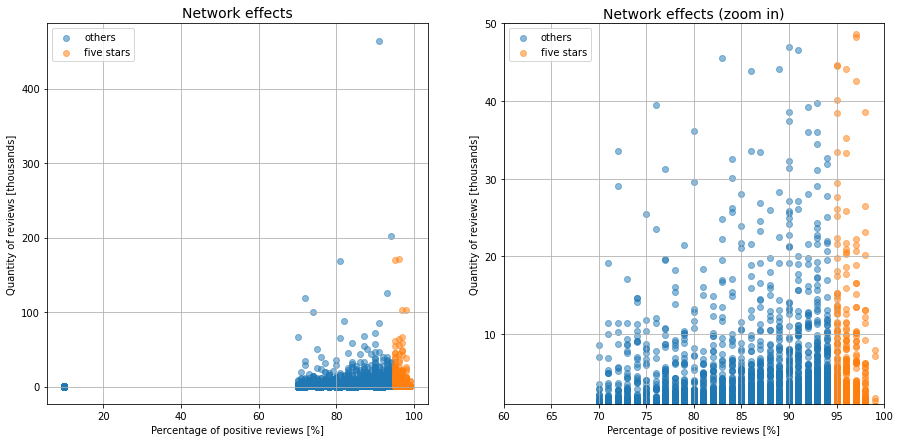

In [18]:
#Figure 7 - Network effects

plt.figure(figsize=(15, 7))

# plot1
plt.subplot(121)
x1=df['positive_reviews'][df.five_stars==0]
x2=df['positive_reviews'][df.five_stars==1]
y1=df.total_reviews[df.five_stars==0]
y2=df.total_reviews[df.five_stars==1]
plt.scatter(x1[df.total_reviews!=0],y1[df.total_reviews!=0],alpha=0.5,label='others')
plt.scatter(x2[df.total_reviews!=0],y2[df.total_reviews!=0],alpha=0.5,label='five stars')
plt.title("Network effects",fontsize=14)
plt.xlabel('Percentage of positive reviews [%]')
plt.ylabel('Quantity of reviews [thousands]')
plt.legend(loc="upper left")
plt.grid()
 
# plot2
plt.subplot(122)
x1=df['positive_reviews'][df.five_stars==0]
x2=df['positive_reviews'][df.five_stars==1]
y1=df.total_reviews[df.five_stars==0]
y2=df.total_reviews[df.five_stars==1]
plt.scatter(x1[df.total_reviews!=0],y1[df.total_reviews!=0],alpha=0.5,label='others')
plt.scatter(x2[df.total_reviews!=0],y2[df.total_reviews!=0],alpha=0.5,label='five stars')
plt.ylim(1,50)
plt.xlim(60,100)
plt.title("Network effects (zoom in)", fontsize=14)
plt.xlabel('Percentage of positive reviews [%]')
plt.ylabel('Quantity of reviews [thousands]')
plt.legend(loc="upper left")
plt.grid()

plt.show()

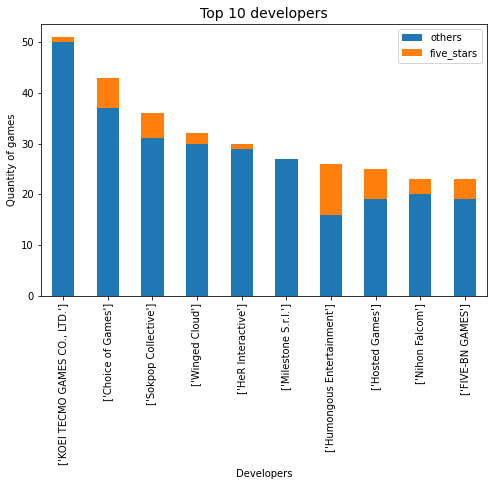

In [19]:
#Figure 8 - top 10 Developers in quantity of games

dev=df.groupby('developers').agg({'title':'count', 'five_stars':'sum'}).sort_values('title',ascending=False)
others=dev['title']-dev['five_stars']
dev['others']=others
dev.pop('title')
dev=dev[['others','five_stars']]
top10_dev=dev[0:10]
top10_dev.plot(kind='bar',stacked=True,figsize=(8, 5))
plt.title("Top 10 developers", fontsize=14)
plt.xlabel('Developers')
plt.ylabel('Quantity of games')

plt.show()

# Regression analysis

Descriptive statistics:

In [21]:
# Summary of all continous variables
df_cont=df.iloc[:,[7,8,10,12,13,15,16]]
df_cont.describe()

,number_languages,compatible_os,price_float,positive_reviews,total_reviews,age,n_tags
count,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000,14006.000000
mean,5.058118,1.529987,10.610728,72.521348,1.199383,4.909325,14.500643
std,5.285837,0.781658,25.679529,31.653927,6.601120,4.728161,5.966918
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,3.900000,75.000000,0.026000,2.000000,9.000000
50%,3.000000,1.000000,8.190000,85.000000,0.121000,4.000000,17.000000
75%,8.000000,2.000000,14.990000,91.000000,0.564000,6.000000,20.000000
max,29.000000,3.000000,2015.000000,99.000000,464.423000,39.000000,20.000000


The regression will analyse the impact of some game characteristics on its review score. So the dependent variable is the ratio of positive reviews of the games while the explanatory ones would be: 

   - the number of operational systems compatible
   - the number of languages available
   - the age of the game in years
   - the number of reviews users did
   - the price of the games
   - the number of tags linked to the game

In [22]:
Y=df['positive_reviews'][df.total_reviews!=0].values
explanat=df.iloc[:,[7,8,10,13,15,16]]
explanat.head()

,number_languages,compatible_os,price_float,total_reviews,age,n_tags
0,7,1,4.99,0.095,8,3
1,1,1,1.99,0.326,1,15
2,1,1,2.39,0.175,3,5
3,2,1,12.49,0.285,4,15
4,2,2,0.00,0.151,11,9


Before running the regression model, we need to check if the explanatory variables are not highly correlated with each other, to avoid multicolitearity problems:

In [23]:
explanat.corr()

,number_languages,compatible_os,price_float,total_reviews,age,n_tags
number_languages,1.000000,0.065318,0.028761,0.077842,-0.089890,0.134688
compatible_os,0.065318,1.000000,-0.027631,0.053218,0.073553,0.042065
price_float,0.028761,-0.027631,1.000000,0.030849,-0.019446,0.033129
total_reviews,0.077842,0.053218,0.030849,1.000000,0.064053,0.124757
age,-0.089890,0.073553,-0.019446,0.064053,1.000000,-0.238401
n_tags,0.134688,0.042065,0.033129,0.124757,-0.238401,1.000000


In the correlation matrix above, we can see that there are no strong correlation between these variables, so they all can be introduced into the model as independet variables. Below we can se the correlation of the review score with each variable:

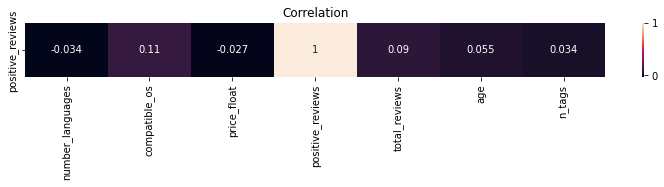

In [24]:
plt.figure(figsize = (13, 1))
corrMatrix = df_cont.corr(method ='pearson')[3:4]
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation')
plt.show()

We can see that the number of compatible OS and the number of reviews are the most correlated with the review score.

Now let's run the OLS model:

$$
Review  Score ≈ \beta_0 + \beta_1 OS + \beta_2 Languages + \beta_3 Price + \beta_4 Reviews + \beta_5 Age + \beta_6 Tags
$$

In [25]:
estm = sm.OLS.from_formula('positive_reviews ~ compatible_os + number_languages + price_float + total_reviews + age + n_tags', df[df.total_reviews!=0]).fit()
estm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,77.3499,0.587,131.860,0.000,76.200,78.500
compatible_os,1.0504,0.205,5.128,0.000,0.649,1.452
number_languages,0.1105,0.031,3.603,0.000,0.050,0.171
price_float,0.0159,0.006,2.655,0.008,0.004,0.028
total_reviews,0.1225,0.023,5.243,0.000,0.077,0.168
age,0.3839,0.035,10.937,0.000,0.315,0.453
n_tags,0.0432,0.028,1.519,0.129,-0.013,0.099


The OLS results show us that the number of tags is not very significant in the model, as its p-value is higher than 10%. From the rest of the explanatory variables, the number of compatible operational systems has the highest coefficient in the equation. However, it's worth mentioning that each variable has a different range, with number of OS range varying from 1-3 and the number of reviews in thousands, for instance.

In [26]:
# Analysing R-squared
estm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       positive_reviews   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     37.17
Date:                Fri, 28 Jan 2022   Prob (F-statistic):           6.23e-45
Time:                        02:09:39   Log-Likelihood:                -53061.
No. Observations:               12330   AIC:                         1.061e+05
Df Residuals:                   12323   BIC:                         1.062e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           77.3499      0.587    131.860      0.000      76.200      78.500
compatible_os        1.0504      0.205      5.128      0.000       0.649       1.452
number_languages     0.1105      0.031      3.603      0.000       0.050       0.171
price_float          0.0159      0.006      2.655      0.008       0.004       0.028
total_reviews        0.1225      0.023      5.243      0.000       0.077       0.168
age                  0.3839      0.035     10.937      0.000       0.315       0.453
n_tags               0.0432      0.028      1.519      0.129      -0.013       0.099
==============================================================================
Omnibus:                     7621.797   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63474.469
Skew:                          -2.994   Prob(JB):                         0.00
Kurtosis:                      12.364   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In most of the cases, having a high r-squared is good for the regression model and a low r-squared is generally a bad sign. However, in some cases, a good model may show a small value like 0.018 that we got. So, we have to analyse deeply and try to discover the source of it. Maybe, a tutor meeting with Pierre-François Darlas can help us to better understand. 